In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from pelops.datasets.featuredataset import FeatureDataset
from pelops.experiment_api.experiment import ExperimentGenerator
from pelops.datasets import chip
from collections import defaultdict
from scipy.spatial.distance import cosine, euclidean
from matplotlib.font_manager import FontProperties
from tqdm import tnrange, tqdm_notebook
from itertools import combinations

In [2]:
# do the comparisons between chips

def is_correct_match3(fd,cam1, cam2, cam3, comparison='cosine'):
    distances = []
    lookup = dict()
    for cam1_chip in cam1:
        cam1_feat = fd.get_feats_for_chip(cam1_chip)
        for cam2_chip in cam2:
            cam2_feat = fd.get_feats_for_chip(cam2_chip)
            for cam3_chip in cam3:
                cam3_feat = fd.get_feats_for_chip(cam3_chip)
                featArray = [cam1_feat,cam2_feat,cam3_feat]
                distance = 0
                for f1,f2 in combinations(featArray,2):
                        distance += 1-(cosine(f1,f2))
                distances.append((distance, cam1_chip, cam2_chip, cam3_chip))
            
    distances.sort(reverse=True)
   
    for i, (distance, chip1, chip2, chip3) in enumerate(distances):
        # return best_match
        if chip1.car_id == chip2.car_id == chip3.car_id:
            return i
    raise ValueError("Huh?")


In [44]:
def is_correct_match4(fd,cam1, cam2, cam3,cam4, comparison='cosine'):
    distances = []
    lookup = dict()
    for cam1_chip in cam1:
        # cam1_feat = fd.get_feats_for_chip(cam1_chip)
        for cam2_chip in cam2:
            # cam2_feat = fd.get_feats_for_chip(cam2_chip)
            for cam3_chip in cam3:
                # cam3_feat = fd.get_feats_for_chip(cam3_chip)
                for cam4_chip in cam4:
                    featArray = [cam1_chip,cam2_chip,cam3_chip,cam4_chip]
                    distance = 0
                    for f1,f2 in combinations(featArray,2):
                            F1 = fd.get_feats_for_chip(f1)
                            F2 = fd.get_feats_for_chip(f2)
                            key1 = (f1.filepath,f2.filepath)
                            key2 = (f2.filepath,f1.filepath)
                            if key1 not in lookup:
                                d = 1-(cosine(F1,F2))
                                lookup[key1] = d
                                lookup[key2] = d
                            distance += lookup[key1]
                    distances.append((distance, cam1_chip, cam2_chip, cam3_chip, cam4_chip))

    distances.sort(reverse=True)
   
    for i, (distance, chip1, chip2, chip3, chip4) in enumerate(distances):
        # return best_match
        if chip1.car_id == chip2.car_id == chip3.car_id == chip4.car_id:
            return i
    raise ValueError("Huh?")

In [46]:
# do EXPERIMENTS, determine 
def preCMC(fd,eg,EXPERIMENTS=100):
   
    num_downs = defaultdict(int)
    for i in range(EXPERIMENTS):
        a = eg.generate()
        num_down = is_correct_match4(fd,a[0], a[1], a[2], a[3])
        num_downs[num_down] += 1
        
    keys = sorted(num_downs)
    vals = [num_downs[key] for key in keys]
    return((keys,np.array(vals)/EXPERIMENTS))

In [47]:
# Generate unprocessed CMC curves 
# the data needs to be summed to make the correct
# CMC curve
def makeManyPreCMC(fd,eg,N=100,EXPERIMENTS=100):
    experimentHolder = []
    for experiment in tnrange(N):
        experimentHolder.append(preCMC(fd,eg,EXPERIMENTS=EXPERIMENTS))
    return experimentHolder

In [48]:
# finalize creation of the CMC curves
# generate statistics on the CMC curves
# return all
import math
def makeCMCStats(experimentHolder,itemsPerCamera,cameras):
    comparisons = int(math.pow(itemsPerCamera,cameras))
    stats = np.zeros((len(experimentHolder),comparisons))

    for index,(keys,vals) in enumerate(experimentHolder):
        for keyIndex in range(len(keys)):
            stats[index,keys[keyIndex]] = vals[keyIndex]


    for index in range(len(stats[:,])):
        total_sum = 0.0
        offsetlen = len(stats[0])
        for sample in range(offsetlen):
            total_sum += stats[index,sample] 
            stats[index,sample] = total_sum         

    gdata = np.zeros((3,comparisons))

    for i in range(comparisons):
        gdata[1,i] = np.average(stats[:,i])
    for i in range(comparisons):
        stddev  = np.std(stats[:,i])
        gdata[0,i] = gdata[1,i] - stddev
        gdata[2,i] = gdata[1,i] + stddev
    
    return (stats,gdata)

In [49]:
DATASETFILE = '/local_data/dgrossman/test4'
ITEMSPERCAMERA = 5
NUMCAMERAS = 4
YRANDOM=1024
DROPPED=0
CMC=100
EXPERIMENTS=100

In [50]:
#do the math
fd_x = FeatureDataset(DATASETFILE)
eg_x = ExperimentGenerator(fd_x, NUMCAMERAS, ITEMSPERCAMERA, DROPPED, YRANDOM)

In [38]:
l = eg_x.generate()

3

In [51]:
experimentHolder = makeManyPreCMC(fd_x,eg_x,N=CMC,EXPERIMENTS=EXPERIMENTS)


In [52]:
stats,gdata = makeCMCStats(experimentHolder,ITEMSPERCAMERA,NUMCAMERAS)

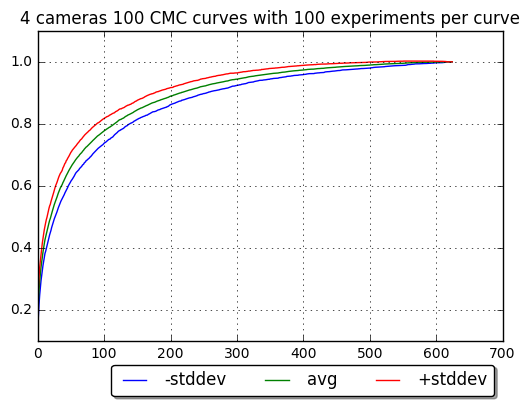

In [53]:
#make the plots
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(gdata.transpose())
plt.title('{} cameras {} CMC curves with {} experiments per curve'.format(NUMCAMERAS,CMC,EXPERIMENTS))
ax.legend(('-stddev','avg','+stddev'),bbox_to_anchor=(1, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.grid(True)

In [ ]:
a = eg_x.generate()

In [ ]:
a[0]